# Train the keras models

## Load the data

In [17]:
import pandas as pd
import numpy as np
import setGPU
import psutil
import importlib
import fit_handler

In [2]:
from models import baseline_model

Using TensorFlow backend.
/usr/local/lib64/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
from models import nlp_model

In [4]:
from data_loader import input_batch_generator
from data_loader import index

In [5]:
importlib.reload(input_batch_generator)

<module 'data_loader.input_batch_generator' from '/nfshome/llayer/AIErrorLogAnalysis/training/data_loader/input_batch_generator.py'>

In [6]:
psutil.cpu_percent(), psutil.virtual_memory()

(2.8,
 svmem(total=101089452032, available=97656963072, percent=3.4, used=2878840832, free=13785038848, active=19354128384, inactive=63162920960, buffers=280866816, cached=84144705536, shared=44711936, slab=3021705216))

In [7]:
actionshist = pd.read_hdf('/nfshome/llayer/data/input_tokens.h5', 'frame')

In [8]:
sites = pd.read_hdf('/nfshome/llayer/data/input_tokens.h5', 'frame2')
codes = pd.read_hdf('/nfshome/llayer/data/input_tokens.h5', 'frame3')

In [9]:
actionshist.head()

,task_name,label,error,site,site_state,count,error_msg_tokenized,exit_codes,steps_counter,error_type
0,/amaltaro_Run2016D-v2-DoubleMuonLowMass-07Aug1...,0,"[-1, -1]","[T1_US_FNAL_Disk, T3_US_FNALLPC]","[bad, bad]","[1, 1]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]"
1,/amaltaro_Run2016D-v2-DoubleMuonLowMass-07Aug1...,0,"[-1, -1]","[T3_US_FNALLPC, T1_US_FNAL_Disk]","[bad, bad]","[1, 1]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]"
2,/amaltaro_Run2016D-v2-DoubleMuonLowMass-07Aug1...,0,"[-1, -1]","[T3_US_FNALLPC, T1_US_FNAL_Disk]","[bad, bad]","[1, 1]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]"
3,/amaltaro_Run2018A-v1-DoubleMuon-17Sep2018_102...,0,"[-1, -1, -1, -1, 85]","[T1_DE_KIT_Disk, T0_CH_CERN_MSS, T0_CH_CERN_Ex...","[bad, bad, bad, bad, good]","[1, 1, 1, 1, 1]","[nan, nan, nan, nan, [[14, 32, 67, 44, 7, 6, 8...","[nan, nan, nan, nan, [85, 8021, 99999, 85]]","[nan, nan, nan, nan, [2, 2, 2, 2]]","[nan, nan, nan, nan, [CMSSWStepFailure, Fatal ..."
4,/amaltaro_Run2018A-v1-DoubleMuon-17Sep2018_102...,0,"[50664, -1, -1]","[T2_DE_RWTH, T2_DE_RWTH, T2_CH_CERN]","[good, good, good]","[2, 1, 1]","[[[17, 1, 6, 189, 280, 179, 7, 341, 3, 140, 13...","[[50664, 143, 50115, 99999, 143], nan, nan]","[[0, 3, 3, 3, 3], nan, nan]","[[PerformanceKill, CMSSWStepFailure, BadFWJRXM..."


In [10]:
psutil.cpu_percent(), psutil.virtual_memory()

(2.2,
 svmem(total=101089452032, available=96620318720, percent=4.4, used=3915485184, free=12748394496, active=20459888640, inactive=63090733056, buffers=280866816, cached=84144705536, shared=44711936, slab=3021918208))

In [11]:
sites_index, codes_index = index.to_index(list(sites['site']), list(codes['error']))

In [20]:
padding_size = 200
dim_errors = len(codes_index)
dim_sites = len(sites_index)
max_msg = 5

## Train the count models

In [31]:
importlib.reload(fit_handler)

<module 'fit_handler' from '/nfshome/llayer/AIErrorLogAnalysis/training/fit_handler.py'>

In [12]:
importlib.reload(input_batch_generator)
padding_size = 200
generator = input_batch_generator.InputBatchGenerator(actionshist, 'label', codes_index, sites_index,
                                                      padding_size)

In [23]:
X, y = generator.get_counts_matrix()

In [24]:
matrix[0].shape

(33586, 77, 153, 2)

In [25]:
psutil.cpu_percent(), psutil.virtual_memory()

(4.2,
 svmem(total=101089452032, available=94146711552, percent=6.9, used=6389075968, free=10268975104, active=22551867392, inactive=63460999168, buffers=464900096, cached=83966500864, shared=44728320, slab=3033956352))

In [32]:
handler = fit_handler.FitHandler()

In [27]:
ff = baseline_model.FF(2, dim_errors, dim_sites)

In [33]:
cv = handler.kfold_val(ff.model_params, X, y, batch_size = 100)

4.5 svmem(total=101089452032, available=87582728192, percent=13.4, used=12953059328, free=3679621120, active=29097201664, inactive=63485423616, buffers=464961536, cached=83991810048, shared=44728320, slab=3034611712)


W0811 09:48:52.399240 140638479628096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 09:48:52.484303 140638479628096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 09:48:52.496279 140638479628096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0811 09:48:52.514187 140638479628096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0811 09:48

Train on 26868 samples, validate on 6718 samples
Epoch 1/100
26868/26868 [==============================] - 7s 277us/step - loss: 0.2771 - acc: 0.9471 - val_loss: 0.2330 - val_acc: 0.9491
0
0.6841378396325402
(0.11510572500655714, 0.11621198575913955)
Epoch 2/100
26868/26868 [==============================] - 4s 165us/step - loss: 0.2375 - acc: 0.9477 - val_loss: 0.2235 - val_acc: 0.9491
0
0.6616957688554301
(0.08188774022239045, 0.08664464237603131)
Epoch 3/100
26868/26868 [==============================] - 4s 165us/step - loss: 0.2311 - acc: 0.9476 - val_loss: 0.2279 - val_acc: 0.9491
0
0.6332060284546582
(0.07658631649335162, 0.07864839878181064)
Epoch 4/100
26868/26868 [==============================] - 4s 164us/step - loss: 0.2296 - acc: 0.9477 - val_loss: 0.2228 - val_acc: 0.9491
0
0.6697798120877266
(0.11503002040573782, 0.11579625226194772)
Epoch 5/100
26868/26868 [==============================] - 4s 164us/step - loss: 0.2307 - acc: 0.9477 - val_loss: 0.2302 - val_acc: 0.9491


KeyboardInterrupt: 

In [ ]:
result = handler.find_optimal_parameters( ff, X, y, batch_size = 1000, num_calls = 20 )

In [ ]:
result[0].to_hdf('skopt_baseline_prune_sites_errors_neg.h5', 'frame')

In [ ]:
prior_names = [a for a in ff.model_params.keys()]
prior_names.append('batch_size')
param_opt = handler.get_results(result[0], prior_names)

In [35]:
skopt_files = ['skopt_baseline.h5', 'skopt_baseline_prune_neg.h5', 'skopt_baseline_prune_sites_errors.h5',
             'skopt_baseline_prune_sites_errors_neg.h5', 'skopt_baseline_prune_sites.h5', 'skopt_baseline_tier.h5']

In [44]:
def load_skopt_results(skopt_files):
    files = []
    for file in skopt_files:
        files.append(pd.read_hdf('skopt_results/' + file).reset_index().rename(columns={"index": "calls"}))
    return files

files = load_skopt_results(skopt_files)        

In [45]:
files[0].head()

,calls,learning_rate,dense_units,dense_layers,regulizer_value,dropout_value,batch_size,cv_score
0,29,0.005675,35,6,0.001000,0.052315,2370,-0.751084
1,27,0.001721,98,4,0.001503,0.132512,500,-0.749619
2,20,0.000926,27,4,0.001235,0.310846,1373,-0.745465
3,16,0.005323,60,8,0.001000,0.010000,1306,-0.745101
4,28,0.001905,60,4,0.001000,0.010000,1585,-0.744474


In [42]:
import matplotlib.pyplot as plt

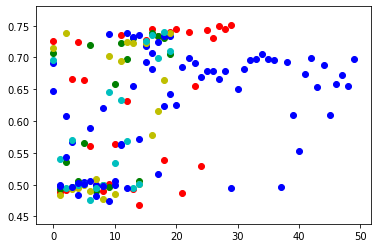

In [48]:
colors = 'rgbycb'
for counter, opt in enumerate(files):
    plt.scatter(opt.calls, opt.cv_score * -1, c=colors[counter])

## Train the error message models

In [12]:
importlib.reload(nlp_model)

<module 'models.nlp_model' from '/nfshome/llayer/AIErrorLogAnalysis/training/models/nlp_model.py'>

In [13]:
importlib.reload(input_batch_generator)
padding_size = 200
batch_size = 1
generator = input_batch_generator.InputBatchGenerator(actionshist, 'label', codes_index, sites_index,
                                                      padding_size, batch_size = batch_size)

In [ ]:
test = generator.msg_count_batch(0, 10)
test[0].shape, test[1].shape

In [74]:
for X,y in generator.gen_batches():
    print( psutil.cpu_percent(), psutil.virtual_memory() )
    print(X[0].shape)

4.4 svmem(total=101089452032, available=91658964992, percent=9.3, used=8876822528, free=8357765120, active=24546885632, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91658203136, percent=9.3, used=8877584384, free=8357003264, active=24547631104, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
5.6 svmem(total=101089452032, available=91657822208, percent=9.3, used=8877965312, free=8356622336, active=24547258368, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91658194944, percent=9.3, used=8877592576, free=8356995072, active=24547258368, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91658194944,

12.0 svmem(total=101089452032, available=91657838592, percent=9.3, used=8877948928, free=8356638720, active=24547328000, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
5.3 svmem(total=101089452032, available=91657838592, percent=9.3, used=8877948928, free=8356638720, active=24547328000, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
10.0 svmem(total=101089452032, available=91657838592, percent=9.3, used=8877948928, free=8356638720, active=24547328000, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
18.2 svmem(total=101089452032, available=91657838592, percent=9.3, used=8877948928, free=8356638720, active=24547328000, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
6.3 svmem(total=101089452032, available=916578385

6.7 svmem(total=101089452032, available=91657838592, percent=9.3, used=8877948928, free=8356638720, active=24547328000, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
12.5 svmem(total=101089452032, available=91657838592, percent=9.3, used=8877948928, free=8356638720, active=24547328000, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91657838592, percent=9.3, used=8877948928, free=8356638720, active=24547328000, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91657838592, percent=9.3, used=8877948928, free=8356638720, active=24547328000, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91657838592

7.7 svmem(total=101089452032, available=91657457664, percent=9.3, used=8878329856, free=8356257792, active=24547700736, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
5.9 svmem(total=101089452032, available=91657457664, percent=9.3, used=8878329856, free=8356257792, active=24547700736, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91657457664, percent=9.3, used=8878329856, free=8356257792, active=24547700736, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91657457664, percent=9.3, used=8878329856, free=8356257792, active=24547700736, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
10.0 svmem(total=101089452032, available=91657457664

7.1 svmem(total=101089452032, available=91657084928, percent=9.3, used=8878702592, free=8355885056, active=24547520512, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91657084928, percent=9.3, used=8878702592, free=8355885056, active=24547520512, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91657084928, percent=9.3, used=8878702592, free=8355885056, active=24547520512, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91657084928, percent=9.3, used=8878702592, free=8355885056, active=24547520512, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91657084928,

11.8 svmem(total=101089452032, available=91655950336, percent=9.3, used=8879837184, free=8354750464, active=24547774464, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
0.0 svmem(total=101089452032, available=91655950336, percent=9.3, used=8879837184, free=8354750464, active=24547774464, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
12.5 svmem(total=101089452032, available=91655950336, percent=9.3, used=8879837184, free=8354750464, active=24547774464, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91655950336, percent=9.3, used=8879837184, free=8354750464, active=24547774464, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=9165595033

8.1 svmem(total=101089452032, available=91655229440, percent=9.3, used=8880558080, free=8354029568, active=24548478976, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
8.7 svmem(total=101089452032, available=91655229440, percent=9.3, used=8880558080, free=8354029568, active=24548851712, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
6.3 svmem(total=101089452032, available=91655602176, percent=9.3, used=8880185344, free=8354402304, active=24548106240, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
11.1 svmem(total=101089452032, available=91655602176, percent=9.3, used=8880185344, free=8354402304, active=24548106240, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91655974912

9.3 svmem(total=101089452032, available=91655573504, percent=9.3, used=8880214016, free=8354373632, active=24548356096, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91655573504, percent=9.3, used=8880214016, free=8354373632, active=24548356096, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
8.6 svmem(total=101089452032, available=91655573504, percent=9.3, used=8880214016, free=8354373632, active=24548356096, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
12.5 svmem(total=101089452032, available=91655573504, percent=9.3, used=8880214016, free=8354373632, active=24547983360, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
6.3 svmem(total=101089452032, available=91655573504

8.3 svmem(total=101089452032, available=91656728576, percent=9.3, used=8879058944, free=8355528704, active=24547446784, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91656347648, percent=9.3, used=8879439872, free=8355147776, active=24547446784, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
10.0 svmem(total=101089452032, available=91656347648, percent=9.3, used=8879439872, free=8355147776, active=24547446784, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91656347648, percent=9.3, used=8879439872, free=8355147776, active=24547446784, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91656347648

9.4 svmem(total=101089452032, available=91655651328, percent=9.3, used=8880136192, free=8354451456, active=24548110336, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
5.9 svmem(total=101089452032, available=91655651328, percent=9.3, used=8880136192, free=8354451456, active=24548110336, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
10.5 svmem(total=101089452032, available=91655651328, percent=9.3, used=8880136192, free=8354451456, active=24548110336, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
8.7 svmem(total=101089452032, available=91655651328, percent=9.3, used=8880136192, free=8354451456, active=24548110336, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
8.6 svmem(total=101089452032, available=91654889472

22.2 svmem(total=101089452032, available=91655847936, percent=9.3, used=8879939584, free=8354648064, active=24547438592, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
10.0 svmem(total=101089452032, available=91655847936, percent=9.3, used=8879939584, free=8354648064, active=24547438592, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
13.3 svmem(total=101089452032, available=91655847936, percent=9.3, used=8879939584, free=8354648064, active=24547438592, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
6.7 svmem(total=101089452032, available=91655847936, percent=9.3, used=8879939584, free=8354648064, active=24547438592, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
6.7 svmem(total=101089452032, available=916558479

11.4 svmem(total=101089452032, available=91653201920, percent=9.3, used=8882585600, free=8352002048, active=24548605952, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
8.8 svmem(total=101089452032, available=91653988352, percent=9.3, used=8881799168, free=8352788480, active=24548192256, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
5.7 svmem(total=101089452032, available=91651375104, percent=9.3, used=8884412416, free=8350175232, active=24550121472, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
10.7 svmem(total=101089452032, available=91653083136, percent=9.3, used=8882704384, free=8351883264, active=24548679680, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
7.0 svmem(total=101089452032, available=9165308313

12.2 svmem(total=101089452032, available=91653554176, percent=9.3, used=8882233344, free=8352354304, active=24549105664, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
7.8 svmem(total=101089452032, available=91615055872, percent=9.4, used=8920731648, free=8313856000, active=24587661312, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91616202752, percent=9.4, used=8919584768, free=8315002880, active=24586420224, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
7.4 svmem(total=101089452032, available=91617443840, percent=9.4, used=8918343680, free=8316243968, active=24585592832, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
7.9 svmem(total=101089452032, available=91610206208

7.7 svmem(total=101089452032, available=91650285568, percent=9.3, used=8885501952, free=8349085696, active=24552448000, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
12.5 svmem(total=101089452032, available=91650387968, percent=9.3, used=8885399552, free=8349188096, active=24551981056, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91650387968, percent=9.3, used=8885399552, free=8349188096, active=24552042496, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91650387968, percent=9.3, used=8885399552, free=8349188096, active=24552042496, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
6.7 svmem(total=101089452032, available=91650387968

7.1 svmem(total=101089452032, available=91650174976, percent=9.3, used=8885612544, free=8348975104, active=24551051264, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
5.9 svmem(total=101089452032, available=91650174976, percent=9.3, used=8885612544, free=8348975104, active=24551051264, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91650174976, percent=9.3, used=8885612544, free=8348975104, active=24551051264, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91650174976, percent=9.3, used=8885612544, free=8348975104, active=24551051264, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
11.1 svmem(total=101089452032, available=91650174976

6.7 svmem(total=101089452032, available=91650174976, percent=9.3, used=8885612544, free=8348975104, active=24551051264, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91650174976, percent=9.3, used=8885612544, free=8348975104, active=24551051264, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91650174976, percent=9.3, used=8885612544, free=8348975104, active=24551051264, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
11.8 svmem(total=101089452032, available=91650174976, percent=9.3, used=8885612544, free=8348975104, active=24551051264, inactive=63475036160, buffers=281927680, cached=83572936704, shared=44728320, slab=2942787584)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91650174976

10.0 svmem(total=101089452032, available=91647864832, percent=9.3, used=8887922688, free=8346664960, active=24553721856, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
22.2 svmem(total=101089452032, available=91647619072, percent=9.3, used=8888168448, free=8346419200, active=24553766912, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
12.5 svmem(total=101089452032, available=91647619072, percent=9.3, used=8888168448, free=8346419200, active=24553766912, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
18.2 svmem(total=101089452032, available=91648372736, percent=9.3, used=8887414784, free=8347172864, active=24553553920, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
11.1 svmem(total=101089452032, available=9164837

9.7 svmem(total=101089452032, available=91647172608, percent=9.3, used=8888614912, free=8345972736, active=24555413504, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91648380928, percent=9.3, used=8887406592, free=8347181056, active=24553816064, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
8.8 svmem(total=101089452032, available=91648380928, percent=9.3, used=8887406592, free=8347181056, active=24553816064, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91648794624, percent=9.3, used=8886992896, free=8347594752, active=24553402368, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
8.7 svmem(total=101089452032, available=91648794624,

14.3 svmem(total=101089452032, available=91648819200, percent=9.3, used=8886968320, free=8347619328, active=24552878080, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91648819200, percent=9.3, used=8886968320, free=8347619328, active=24552878080, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
6.7 svmem(total=101089452032, available=91648819200, percent=9.3, used=8886968320, free=8347619328, active=24553250816, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91648819200, percent=9.3, used=8886968320, free=8347619328, active=24553250816, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
0.0 svmem(total=101089452032, available=91648819200

8.3 svmem(total=101089452032, available=91649265664, percent=9.3, used=8886521856, free=8348065792, active=24552796160, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
10.0 svmem(total=101089452032, available=91648884736, percent=9.3, used=8886902784, free=8347684864, active=24552796160, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
10.0 svmem(total=101089452032, available=91648884736, percent=9.3, used=8886902784, free=8347684864, active=24552796160, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
0.0 svmem(total=101089452032, available=91648884736, percent=9.3, used=8886902784, free=8347684864, active=24552796160, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
18.2 svmem(total=101089452032, available=916488847

12.5 svmem(total=101089452032, available=91648147456, percent=9.3, used=8887640064, free=8346947584, active=24552505344, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
0.0 svmem(total=101089452032, available=91648147456, percent=9.3, used=8887640064, free=8346947584, active=24552505344, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91648147456, percent=9.3, used=8887640064, free=8346947584, active=24552505344, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91648147456, percent=9.3, used=8887640064, free=8346947584, active=24552505344, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942795776)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91648147456

10.0 svmem(total=101089452032, available=91649175552, percent=9.3, used=8886611968, free=8347975680, active=24552140800, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942812160)
(10, 77, 153, 5, 200)
11.1 svmem(total=101089452032, available=91649175552, percent=9.3, used=8886611968, free=8347975680, active=24552140800, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942812160)
(10, 77, 153, 5, 200)
10.0 svmem(total=101089452032, available=91649175552, percent=9.3, used=8886611968, free=8347975680, active=24552513536, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942812160)
(10, 77, 153, 5, 200)
0.0 svmem(total=101089452032, available=91649175552, percent=9.3, used=8886611968, free=8347975680, active=24552513536, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942812160)
(10, 77, 153, 5, 200)
10.0 svmem(total=101089452032, available=91648794

5.6 svmem(total=101089452032, available=91649273856, percent=9.3, used=8886513664, free=8348073984, active=24552239104, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942812160)
(10, 77, 153, 5, 200)
12.5 svmem(total=101089452032, available=91649273856, percent=9.3, used=8886513664, free=8348073984, active=24552611840, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942812160)
(10, 77, 153, 5, 200)
6.7 svmem(total=101089452032, available=91649273856, percent=9.3, used=8886513664, free=8348073984, active=24552611840, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942812160)
(10, 77, 153, 5, 200)
11.1 svmem(total=101089452032, available=91648892928, percent=9.3, used=8886894592, free=8347693056, active=24552611840, inactive=63475027968, buffers=281927680, cached=83572936704, shared=44728320, slab=2942812160)
(10, 77, 153, 5, 200)
11.1 svmem(total=101089452032, available=916489256

11.1 svmem(total=101089452032, available=91648163840, percent=9.3, used=8887623680, free=8346951680, active=24552353792, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
11.1 svmem(total=101089452032, available=91648577536, percent=9.3, used=8887209984, free=8347365376, active=24552353792, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
0.0 svmem(total=101089452032, available=91648577536, percent=9.3, used=8887209984, free=8347365376, active=24551940096, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
12.5 svmem(total=101089452032, available=91648577536, percent=9.3, used=8887209984, free=8347365376, active=24551940096, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
11.1 svmem(total=101089452032, available=91648577

11.5 svmem(total=101089452032, available=91647524864, percent=9.3, used=8888262656, free=8346312704, active=24552562688, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91647152128, percent=9.3, used=8888635392, free=8345939968, active=24553308160, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91647524864, percent=9.3, used=8888262656, free=8346312704, active=24552562688, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91647524864, percent=9.3, used=8888262656, free=8346312704, active=24552935424, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91647565824

9.2 svmem(total=101089452032, available=91645747200, percent=9.3, used=8890040320, free=8344535040, active=24554377216, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
7.0 svmem(total=101089452032, available=91646111744, percent=9.3, used=8889675776, free=8344899584, active=24554004480, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
10.5 svmem(total=101089452032, available=91646033920, percent=9.3, used=8889753600, free=8344821760, active=24554336256, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
7.8 svmem(total=101089452032, available=91645263872, percent=9.3, used=8890523648, free=8344051712, active=24555081728, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91646795776

10.0 svmem(total=101089452032, available=91647385600, percent=9.3, used=8888401920, free=8346173440, active=24553242624, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
9.7 svmem(total=101089452032, available=91647385600, percent=9.3, used=8888401920, free=8346173440, active=24552828928, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91647758336, percent=9.3, used=8888029184, free=8346546176, active=24552456192, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
9.5 svmem(total=101089452032, available=91647758336, percent=9.3, used=8888029184, free=8346546176, active=24552456192, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91647758336

13.2 svmem(total=101089452032, available=91647381504, percent=9.3, used=8888406016, free=8346169344, active=24553037824, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
5.9 svmem(total=101089452032, available=91647754240, percent=9.3, used=8888033280, free=8346542080, active=24552665088, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91647754240, percent=9.3, used=8888033280, free=8346542080, active=24552665088, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
9.5 svmem(total=101089452032, available=91647754240, percent=9.3, used=8888033280, free=8346542080, active=24552665088, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
6.2 svmem(total=101089452032, available=91647754240

8.4 svmem(total=101089452032, available=91643428864, percent=9.3, used=8892358656, free=8342216704, active=24555524096, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
8.1 svmem(total=101089452032, available=91644157952, percent=9.3, used=8891629568, free=8342945792, active=24554778624, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
6.7 svmem(total=101089452032, available=91646062592, percent=9.3, used=8889724928, free=8344850432, active=24553287680, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91646062592, percent=9.3, used=8889724928, free=8344850432, active=24553287680, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91646435328,

11.8 svmem(total=101089452032, available=91646091264, percent=9.3, used=8889696256, free=8344879104, active=24553123840, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91646091264, percent=9.3, used=8889696256, free=8344879104, active=24553123840, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91646091264, percent=9.3, used=8889696256, free=8344879104, active=24553123840, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91646091264, percent=9.3, used=8889696256, free=8344879104, active=24553123840, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91646091264

8.3 svmem(total=101089452032, available=91644375040, percent=9.3, used=8891412480, free=8343162880, active=24553635840, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
10.9 svmem(total=101089452032, available=91644002304, percent=9.3, used=8891785216, free=8342790144, active=24554381312, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91643232256, percent=9.3, used=8892555264, free=8342020096, active=24554754048, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
6.2 svmem(total=101089452032, available=91643232256, percent=9.3, used=8892555264, free=8342020096, active=24554381312, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
11.1 svmem(total=101089452032, available=9164397772

10.5 svmem(total=101089452032, available=91646218240, percent=9.3, used=8889569280, free=8345006080, active=24552112128, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91646218240, percent=9.3, used=8889569280, free=8345006080, active=24552484864, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
6.7 svmem(total=101089452032, available=91646218240, percent=9.3, used=8889569280, free=8345006080, active=24552484864, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
6.7 svmem(total=101089452032, available=91646218240, percent=9.3, used=8889569280, free=8345006080, active=24552484864, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
10.5 svmem(total=101089452032, available=9164621824

7.1 svmem(total=101089452032, available=91645091840, percent=9.3, used=8890695680, free=8343879680, active=24552579072, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
5.9 svmem(total=101089452032, available=91645505536, percent=9.3, used=8890281984, free=8344293376, active=24552579072, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
12.0 svmem(total=101089452032, available=91645505536, percent=9.3, used=8890281984, free=8344293376, active=24552579072, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
10.0 svmem(total=101089452032, available=91645505536, percent=9.3, used=8890281984, free=8344293376, active=24552579072, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
8.0 svmem(total=101089452032, available=9164550553

8.2 svmem(total=101089452032, available=91644272640, percent=9.3, used=8891514880, free=8343060480, active=24553533440, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91644645376, percent=9.3, used=8891142144, free=8343433216, active=24553160704, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
6.7 svmem(total=101089452032, available=91645018112, percent=9.3, used=8890769408, free=8343805952, active=24552787968, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
10.0 svmem(total=101089452032, available=91645018112, percent=9.3, used=8890769408, free=8343805952, active=24552787968, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91645018112

8.2 svmem(total=101089452032, available=91642425344, percent=9.3, used=8893362176, free=8341213184, active=24554680320, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942791680)
(10, 77, 153, 5, 200)
13.0 svmem(total=101089452032, available=91644702720, percent=9.3, used=8891084800, free=8343490560, active=24552775680, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942791680)
(10, 77, 153, 5, 200)
8.7 svmem(total=101089452032, available=91644702720, percent=9.3, used=8891084800, free=8343490560, active=24553148416, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942791680)
(10, 77, 153, 5, 200)
5.6 svmem(total=101089452032, available=91644702720, percent=9.3, used=8891084800, free=8343490560, active=24553148416, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942791680)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91644702720

6.3 svmem(total=101089452032, available=91645140992, percent=9.3, used=8890646528, free=8343928832, active=24551968768, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
10.3 svmem(total=101089452032, available=91644760064, percent=9.3, used=8891027456, free=8343547904, active=24551968768, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
5.3 svmem(total=101089452032, available=91644760064, percent=9.3, used=8891027456, free=8343547904, active=24551555072, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
9.8 svmem(total=101089452032, available=91644792832, percent=9.3, used=8890994688, free=8343580672, active=24552300544, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942783488)
(10, 77, 153, 5, 200)
8.8 svmem(total=101089452032, available=91644411904

5.9 svmem(total=101089452032, available=91645202432, percent=9.3, used=8890585088, free=8343990272, active=24551661568, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
9.5 svmem(total=101089452032, available=91645202432, percent=9.3, used=8890585088, free=8343990272, active=24551661568, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91645202432, percent=9.3, used=8890585088, free=8343990272, active=24551661568, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91645202432, percent=9.3, used=8890585088, free=8343990272, active=24551661568, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91645202432,

10.0 svmem(total=101089452032, available=91645095936, percent=9.3, used=8890691584, free=8343883776, active=24551636992, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
6.7 svmem(total=101089452032, available=91645095936, percent=9.3, used=8890691584, free=8343883776, active=24551636992, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
12.5 svmem(total=101089452032, available=91645509632, percent=9.3, used=8890277888, free=8344297472, active=24551636992, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
5.3 svmem(total=101089452032, available=91645509632, percent=9.3, used=8890277888, free=8344297472, active=24551636992, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
9.4 svmem(total=101089452032, available=9164550963

9.8 svmem(total=101089452032, available=91644137472, percent=9.3, used=8891650048, free=8342925312, active=24552632320, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
8.2 svmem(total=101089452032, available=91644170240, percent=9.3, used=8891617280, free=8342958080, active=24553005056, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
13.3 svmem(total=101089452032, available=91645288448, percent=9.3, used=8890499072, free=8344076288, active=24551886848, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91645288448, percent=9.3, used=8890499072, free=8344076288, active=24551886848, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
5.3 svmem(total=101089452032, available=91645288448

7.1 svmem(total=101089452032, available=91646001152, percent=9.3, used=8889786368, free=8344788992, active=24551387136, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
8.7 svmem(total=101089452032, available=91645620224, percent=9.3, used=8890167296, free=8344408064, active=24551759872, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
7.4 svmem(total=101089452032, available=91645239296, percent=9.3, used=8890548224, free=8344027136, active=24552132608, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
8.1 svmem(total=101089452032, available=91644874752, percent=9.3, used=8890912768, free=8343662592, active=24552148992, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942775296)
(10, 77, 153, 5, 200)
5.6 svmem(total=101089452032, available=91644882944,

8.3 svmem(total=101089452032, available=91646029824, percent=9.3, used=8889757696, free=8344817664, active=24550998016, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942767104)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91646443520, percent=9.3, used=8889344000, free=8345231360, active=24550998016, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942767104)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91646443520, percent=9.3, used=8889344000, free=8345231360, active=24550998016, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942767104)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91646062592, percent=9.3, used=8889724928, free=8344850432, active=24550998016, inactive=63475036160, buffers=281927680, cached=83572948992, shared=44728320, slab=2942767104)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91646062592,

13.3 svmem(total=101089452032, available=91644231680, percent=9.3, used=8891555840, free=8343052288, active=24552009728, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91644919808, percent=9.3, used=8890867712, free=8343740416, active=24551616512, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
16.7 svmem(total=101089452032, available=91644919808, percent=9.3, used=8890867712, free=8343740416, active=24551616512, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
11.8 svmem(total=101089452032, available=91644919808, percent=9.3, used=8890867712, free=8343740416, active=24551616512, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
5.9 svmem(total=101089452032, available=916449198

8.5 svmem(total=101089452032, available=91643310080, percent=9.3, used=8892477440, free=8342130688, active=24552624128, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.7 svmem(total=101089452032, available=91643682816, percent=9.3, used=8892104704, free=8342503424, active=24551878656, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91644055552, percent=9.3, used=8891731968, free=8342876160, active=24551505920, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91644055552, percent=9.3, used=8891731968, free=8342876160, active=24551505920, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91644055552,

11.1 svmem(total=101089452032, available=91644792832, percent=9.3, used=8890994688, free=8343613440, active=24552005632, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91644792832, percent=9.3, used=8890994688, free=8343613440, active=24551632896, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91644792832, percent=9.3, used=8890994688, free=8343613440, active=24551632896, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91644792832, percent=9.3, used=8890994688, free=8343613440, active=24551632896, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91644792832

8.3 svmem(total=101089452032, available=91645485056, percent=9.3, used=8890302464, free=8344305664, active=24551546880, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91645485056, percent=9.3, used=8890302464, free=8344305664, active=24551546880, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91645493248, percent=9.3, used=8890294272, free=8344313856, active=24551473152, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
0.0 svmem(total=101089452032, available=91645493248, percent=9.3, used=8890294272, free=8344313856, active=24551100416, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
12.5 svmem(total=101089452032, available=91645493248

8.7 svmem(total=101089452032, available=91645243392, percent=9.3, used=8890544128, free=8344064000, active=24551641088, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
5.6 svmem(total=101089452032, available=91645243392, percent=9.3, used=8890544128, free=8344064000, active=24551641088, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91645243392, percent=9.3, used=8890544128, free=8344064000, active=24551641088, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
10.0 svmem(total=101089452032, available=91645243392, percent=9.3, used=8890544128, free=8344064000, active=24551641088, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91645243392

7.1 svmem(total=101089452032, available=91644760064, percent=9.3, used=8891027456, free=8343580672, active=24551763968, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91644760064, percent=9.3, used=8891027456, free=8343580672, active=24551763968, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
5.0 svmem(total=101089452032, available=91644760064, percent=9.3, used=8891027456, free=8343580672, active=24551763968, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91644760064, percent=9.3, used=8891027456, free=8343580672, active=24551763968, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
10.5 svmem(total=101089452032, available=91644760064

9.5 svmem(total=101089452032, available=91644399616, percent=9.3, used=8891387904, free=8343220224, active=24551972864, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
10.0 svmem(total=101089452032, available=91644399616, percent=9.3, used=8891387904, free=8343220224, active=24551972864, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91644399616, percent=9.3, used=8891387904, free=8343220224, active=24551600128, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.5 svmem(total=101089452032, available=91644399616, percent=9.3, used=8891387904, free=8343220224, active=24551972864, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91644399616

12.5 svmem(total=101089452032, available=91644977152, percent=9.3, used=8890810368, free=8343797760, active=24551272448, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.0 svmem(total=101089452032, available=91644977152, percent=9.3, used=8890810368, free=8343797760, active=24551645184, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91644977152, percent=9.3, used=8890810368, free=8343797760, active=24551645184, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.6 svmem(total=101089452032, available=91644596224, percent=9.3, used=8891191296, free=8343416832, active=24552390656, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.6 svmem(total=101089452032, available=91643826176

8.0 svmem(total=101089452032, available=91644170240, percent=9.3, used=8891617280, free=8342990848, active=24552226816, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.2 svmem(total=101089452032, available=91644194816, percent=9.3, used=8891592704, free=8343015424, active=24552599552, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91644186624, percent=9.3, used=8891600896, free=8343007232, active=24552226816, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.5 svmem(total=101089452032, available=91644559360, percent=9.3, used=8891228160, free=8343379968, active=24551854080, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
10.5 svmem(total=101089452032, available=91644932096

9.3 svmem(total=101089452032, available=91644366848, percent=9.3, used=8891420672, free=8343187456, active=24552243200, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91645485056, percent=9.3, used=8890302464, free=8344305664, active=24551497728, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.6 svmem(total=101089452032, available=91644628992, percent=9.3, used=8891158528, free=8343449600, active=24552615936, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91644993536, percent=9.3, used=8890793984, free=8343814144, active=24551870464, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.7 svmem(total=101089452032, available=91644993536,

13.3 svmem(total=101089452032, available=91645591552, percent=9.3, used=8890195968, free=8344412160, active=24551002112, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91645591552, percent=9.3, used=8890195968, free=8344412160, active=24551002112, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91645591552, percent=9.3, used=8890195968, free=8344412160, active=24551002112, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91645591552, percent=9.3, used=8890195968, free=8344412160, active=24551002112, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
0.0 svmem(total=101089452032, available=91645591552

14.3 svmem(total=101089452032, available=91645521920, percent=9.3, used=8890265600, free=8344342528, active=24551333888, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91645521920, percent=9.3, used=8890265600, free=8344342528, active=24551333888, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91645521920, percent=9.3, used=8890265600, free=8344342528, active=24551333888, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91645521920, percent=9.3, used=8890265600, free=8344342528, active=24551333888, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
14.3 svmem(total=101089452032, available=9164580044

8.8 svmem(total=101089452032, available=91646095360, percent=9.3, used=8889692160, free=8344915968, active=24551673856, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.0 svmem(total=101089452032, available=91645222912, percent=9.3, used=8890564608, free=8344043520, active=24552419328, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
6.7 svmem(total=101089452032, available=91646341120, percent=9.3, used=8889446400, free=8345161728, active=24551301120, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91646341120, percent=9.3, used=8889446400, free=8345161728, active=24552046592, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
12.0 svmem(total=101089452032, available=91645960192

9.7 svmem(total=101089452032, available=91644153856, percent=9.3, used=8891633664, free=8342974464, active=24552931328, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.9 svmem(total=101089452032, available=91644551168, percent=9.3, used=8891236352, free=8343371776, active=24552517632, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.5 svmem(total=101089452032, available=91644887040, percent=9.3, used=8890900480, free=8343707648, active=24552849408, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91644887040, percent=9.3, used=8890900480, free=8343707648, active=24552849408, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91644887040,

9.4 svmem(total=101089452032, available=91644100608, percent=9.3, used=8891686912, free=8342921216, active=24553443328, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.5 svmem(total=101089452032, available=91644133376, percent=9.3, used=8891654144, free=8342953984, active=24553029632, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.0 svmem(total=101089452032, available=91644547072, percent=9.3, used=8891240448, free=8343367680, active=24553029632, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91644547072, percent=9.3, used=8891240448, free=8343367680, active=24552574976, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91644960768,

7.7 svmem(total=101089452032, available=91645784064, percent=9.3, used=8890003456, free=8344604672, active=24551763968, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.1 svmem(total=101089452032, available=91645063168, percent=9.3, used=8890724352, free=8343883776, active=24552468480, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.4 svmem(total=101089452032, available=91645087744, percent=9.3, used=8890699776, free=8343908352, active=24552054784, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.2 svmem(total=101089452032, available=91644399616, percent=9.3, used=8891387904, free=8343220224, active=24553091072, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
6.3 svmem(total=101089452032, available=91645558784,

7.9 svmem(total=101089452032, available=91645231104, percent=9.3, used=8890556416, free=8344051712, active=24552259584, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
8.8 svmem(total=101089452032, available=91645255680, percent=9.3, used=8890531840, free=8344076288, active=24552218624, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91645255680, percent=9.3, used=8890531840, free=8344076288, active=24552218624, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
6.7 svmem(total=101089452032, available=91645628416, percent=9.3, used=8890159104, free=8344449024, active=24551845888, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
7.4 svmem(total=101089452032, available=91646042112,

7.7 svmem(total=101089452032, available=91646013440, percent=9.3, used=8889774080, free=8344834048, active=24551460864, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
8.7 svmem(total=101089452032, available=91645632512, percent=9.3, used=8890155008, free=8344453120, active=24551833600, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91645632512, percent=9.3, used=8890155008, free=8344453120, active=24551833600, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
5.0 svmem(total=101089452032, available=91646046208, percent=9.3, used=8889741312, free=8344866816, active=24551419904, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91646046208,

11.8 svmem(total=101089452032, available=91645698048, percent=9.3, used=8890089472, free=8344518656, active=24551514112, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91646111744, percent=9.3, used=8889675776, free=8344932352, active=24551514112, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91646111744, percent=9.3, used=8889675776, free=8344932352, active=24551514112, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
10.0 svmem(total=101089452032, available=91646144512, percent=9.3, used=8889643008, free=8344965120, active=24551473152, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
5.0 svmem(total=101089452032, available=9164576358

10.0 svmem(total=101089452032, available=91646038016, percent=9.3, used=8889749504, free=8344858624, active=24551772160, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
10.8 svmem(total=101089452032, available=91645689856, percent=9.3, used=8890097664, free=8344510464, active=24552103936, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91645689856, percent=9.3, used=8890097664, free=8344510464, active=24551731200, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
6.7 svmem(total=101089452032, available=91646103552, percent=9.3, used=8889683968, free=8344924160, active=24551317504, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
6.3 svmem(total=101089452032, available=9164610355

7.7 svmem(total=101089452032, available=91646402560, percent=9.3, used=8889384960, free=8345223168, active=24551256064, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91646402560, percent=9.3, used=8889384960, free=8345223168, active=24551256064, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91646402560, percent=9.3, used=8889384960, free=8345223168, active=24550842368, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
6.7 svmem(total=101089452032, available=91646349312, percent=9.3, used=8889438208, free=8345169920, active=24551587840, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
6.9 svmem(total=101089452032, available=91645968384,

5.9 svmem(total=101089452032, available=91645911040, percent=9.3, used=8889876480, free=8344731648, active=24551759872, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91645911040, percent=9.3, used=8889876480, free=8344731648, active=24551759872, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
12.5 svmem(total=101089452032, available=91646324736, percent=9.3, used=8889462784, free=8345145344, active=24551346176, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
5.6 svmem(total=101089452032, available=91646324736, percent=9.3, used=8889462784, free=8345145344, active=24551346176, inactive=63475036160, buffers=281927680, cached=83572916224, shared=44728320, slab=2942726144)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91645571072

5.9 svmem(total=101089452032, available=91646050304, percent=9.3, used=8889737216, free=8344870912, active=24551444480, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.7 svmem(total=101089452032, available=91646050304, percent=9.3, used=8889737216, free=8344870912, active=24551444480, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
6.7 svmem(total=101089452032, available=91646464000, percent=9.3, used=8889323520, free=8345284608, active=24551030784, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
9.5 svmem(total=101089452032, available=91646156800, percent=9.3, used=8889630720, free=8344977408, active=24551321600, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
11.8 svmem(total=101089452032, available=91646156800

8.3 svmem(total=101089452032, available=91644710912, percent=9.3, used=8891076608, free=8343531520, active=24552611840, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.5 svmem(total=101089452032, available=91643932672, percent=9.3, used=8891854848, free=8342753280, active=24552570880, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.7 svmem(total=101089452032, available=91644260352, percent=9.3, used=8891527168, free=8343080960, active=24552902656, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
5.3 svmem(total=101089452032, available=91645005824, percent=9.3, used=8890781696, free=8343826432, active=24551743488, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91645005824,

9.1 svmem(total=101089452032, available=91645837312, percent=9.3, used=8889950208, free=8344657920, active=24551727104, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
4.8 svmem(total=101089452032, available=91645870080, percent=9.3, used=8889917440, free=8344690688, active=24552099840, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
9.5 svmem(total=101089452032, available=91645489152, percent=9.3, used=8890298368, free=8344309760, active=24551686144, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
4.5 svmem(total=101089452032, available=91645521920, percent=9.3, used=8890265600, free=8344342528, active=24551645184, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
11.5 svmem(total=101089452032, available=91645554688

9.1 svmem(total=101089452032, available=91644178432, percent=9.3, used=8891609088, free=8342999040, active=24552275968, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
8.3 svmem(total=101089452032, available=91644178432, percent=9.3, used=8891609088, free=8342999040, active=24551489536, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
11.8 svmem(total=101089452032, available=91644592128, percent=9.3, used=8891195392, free=8343412736, active=24551489536, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
7.1 svmem(total=101089452032, available=91644592128, percent=9.3, used=8891195392, free=8343412736, active=24551489536, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
5.6 svmem(total=101089452032, available=91645005824

8.3 svmem(total=101089452032, available=91644649472, percent=9.3, used=8891138048, free=8343470080, active=24551956480, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
9.5 svmem(total=101089452032, available=91644682240, percent=9.3, used=8891105280, free=8343502848, active=24551542784, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
6.3 svmem(total=101089452032, available=91644682240, percent=9.3, used=8891105280, free=8343502848, active=24551542784, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
9.1 svmem(total=101089452032, available=91645095936, percent=9.3, used=8890691584, free=8343916544, active=24551501824, inactive=63475027968, buffers=281927680, cached=83572916224, shared=44728320, slab=2942734336)
(10, 77, 153, 5, 200)
6.2 svmem(total=101089452032, available=91645095936,

In [15]:
model = nlp_model.NLP_Model(2, dim_errors, dim_sites, padding_size, max_msg, debug=True)

In [16]:
model.create_model(**model.model_params)

W0811 08:57:35.896705 140545380960064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 08:57:35.917879 140545380960064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 08:57:35.928663 140545380960064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 08:57:35.936382 140545380960064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0811 08:57:35.936874 1405453809

Tensor("input_2:0", shape=(?, 77, 153, 5, 200), dtype=float32)
Tensor("reshape_1/Reshape:0", shape=(?, 58905, 200), dtype=float32)


W0811 08:57:37.874964 140545380960064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0811 08:57:37.883477 140545380960064 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tensor("time_distributed_1/Reshape_1:0", shape=(?, 58905, 10), dtype=float32)
Tensor("reshape_2/Reshape:0", shape=(?, 11781, 5, 10), dtype=float32)
Tensor("lambda_1/Mean:0", shape=(?, 11781, 10), dtype=float32)
Tensor("reshape_3/Reshape:0", shape=(?, 77, 153, 10), dtype=float32)
Tensor("input_1:0", shape=(?, 77, 153, 2), dtype=float32)
Tensor("concatenate_1/concat:0", shape=(?, 77, 153, 12), dtype=float32)
Tensor("time_distributed_2/Reshape_1:0", shape=(?, 77, 10), dtype=float32)
Tensor("flatten_2/Reshape:0", shape=(?, ?), dtype=float32)
Tensor("dense_2/Relu:0", shape=(?, 10), dtype=float32)
Tensor("dense_3/Sigmoid:0", shape=(?, 1), dtype=float32)


In [137]:
model.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 77, 153, 5, 2 0                                            
__________________________________________________________________________________________________
reshape_26 (Reshape)            (None, 58905, 200)   0           input_34[0][0]                   
__________________________________________________________________________________________________
time_distributed_11 (TimeDistri (None, 58905, 10)    1635740     reshape_26[0][0]                 
__________________________________________________________________________________________________
reshape_27 (Reshape)            (None, 11781, 5, 10) 0           time_distributed_11[0][0]        
__________________________________________________________________________________________________
lambda_10 

In [17]:
steps_per_epoch = int(len(actionshist) / batch_size)

In [18]:
steps_per_epoch

33586

In [19]:
psutil.cpu_percent(), psutil.virtual_memory()

(4.8,
 svmem(total=101089452032, available=93577891840, percent=7.4, used=6936924160, free=9593868288, active=22818115584, inactive=63833616384, buffers=462155776, cached=84096503808, shared=65699840, slab=3015208960))

In [20]:
model.model.fit_generator(generator = generator.gen_batches(), steps_per_epoch = steps_per_epoch)

Epoch 1/1
   36/33586 [..............................] - ETA: 11:44:31 - loss: 0.0096

KeyboardInterrupt: 